# Importing and initializing modules... #

In [20]:
import cv2
import numpy as np

import macros
import pipeline_phase1
import salama_preprocessing_techniques
import salama_lane_detection_algorithm

import importlib
importlib.reload(macros)

PREVIEW_SIZE_FACTOR = 2
WIDTH = 1280 // PREVIEW_SIZE_FACTOR
HEIGHT = 720 // PREVIEW_SIZE_FACTOR
macros.initialize_preview(WIDTH, HEIGHT, PREVIEW_SIZE_FACTOR)


# Loading the sample data... #
Let's check the first one for now

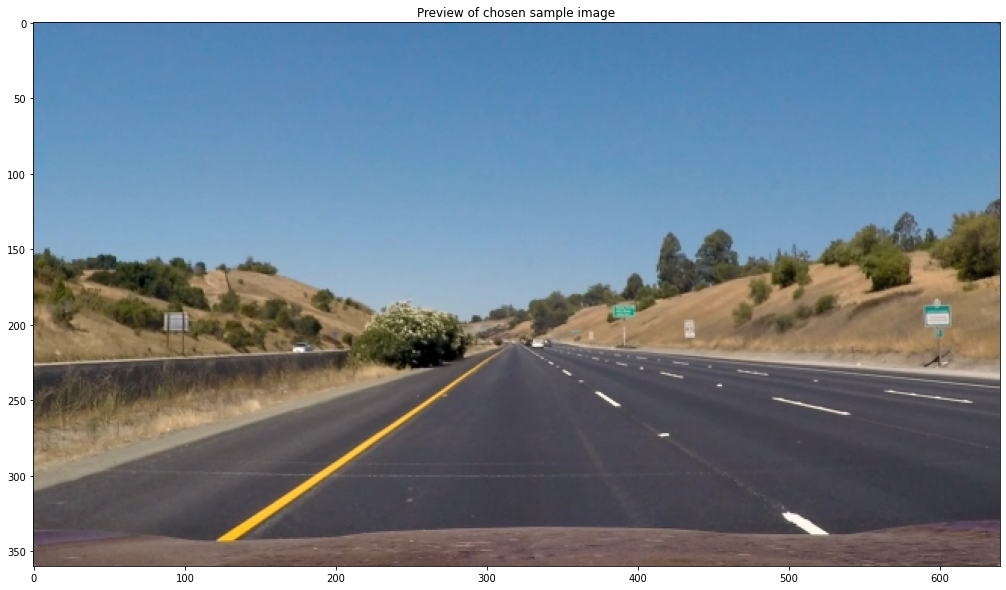

In [2]:
test_image_BGR = macros.load_image("./assets/test_images/straight_lines1.jpg", (WIDTH, HEIGHT))
test_image_RGB = cv2.cvtColor(test_image_BGR, cv2.COLOR_BGR2RGB)
macros.show(test_image_RGB, 'Preview of chosen sample image')


# Next, let's evaluate our channels #

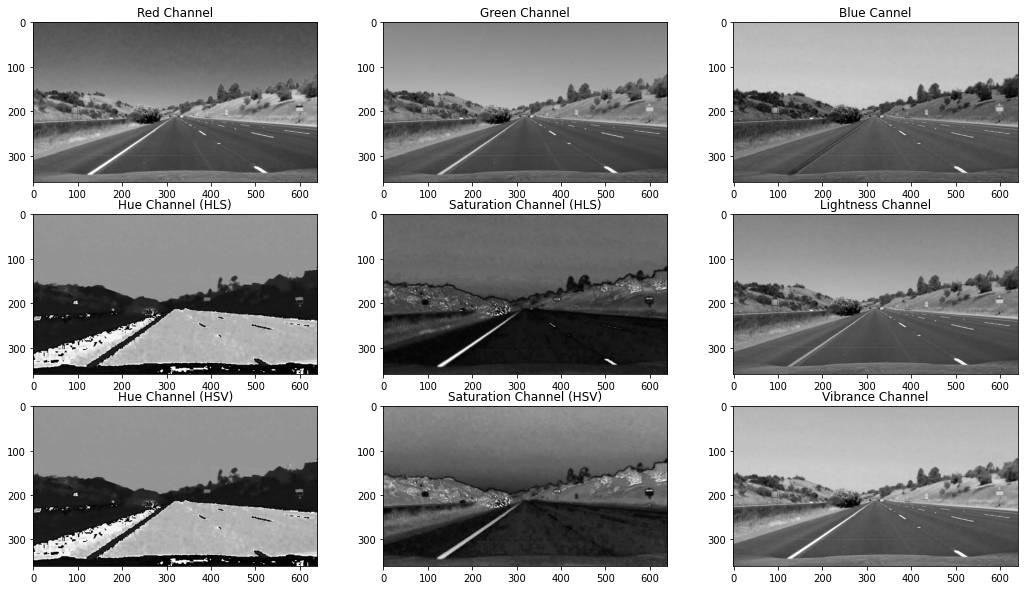

In [3]:
test_image_HLS = cv2.cvtColor(test_image_RGB, cv2.COLOR_RGB2HLS)
test_image_HSV = cv2.cvtColor(test_image_RGB, cv2.COLOR_RGB2HSV)

test_image_RGB_R = test_image_RGB[:, :, 0]
test_image_RGB_G = test_image_RGB[:, :, 1]
test_image_RGB_B = test_image_RGB[:, :, 2]

test_image_HLS_H = test_image_HLS[:, :, 0]
test_image_HLS_L = test_image_HLS[:, :, 1]
test_image_HLS_S = test_image_HLS[:, :, 2]

test_image_HSV_H = test_image_HSV[:, :, 0]
test_image_HSV_S = test_image_HSV[:, :, 1]
test_image_HSV_V = test_image_HSV[:, :, 2]

macros.grid_plot([

    [test_image_RGB_R, "Red Channel"],
    [test_image_RGB_G, "Green Channel"],
    [test_image_RGB_B, "Blue Cannel"],

    [test_image_HLS_H, "Hue Channel (HLS)"],
    [test_image_HLS_S, "Saturation Channel (HLS)"],
    [test_image_HLS_L, "Lightness Channel"],

    [test_image_HSV_H, "Hue Channel (HSV)"],
    [test_image_HSV_S, "Saturation Channel (HSV)"],
    [test_image_HSV_V, "Vibrance Channel"],

], rows=3)


# The S Channel from HLS seems to give best lane details #
But its L gives somewhat useful details too... HSV's V too... hmm, combine them?

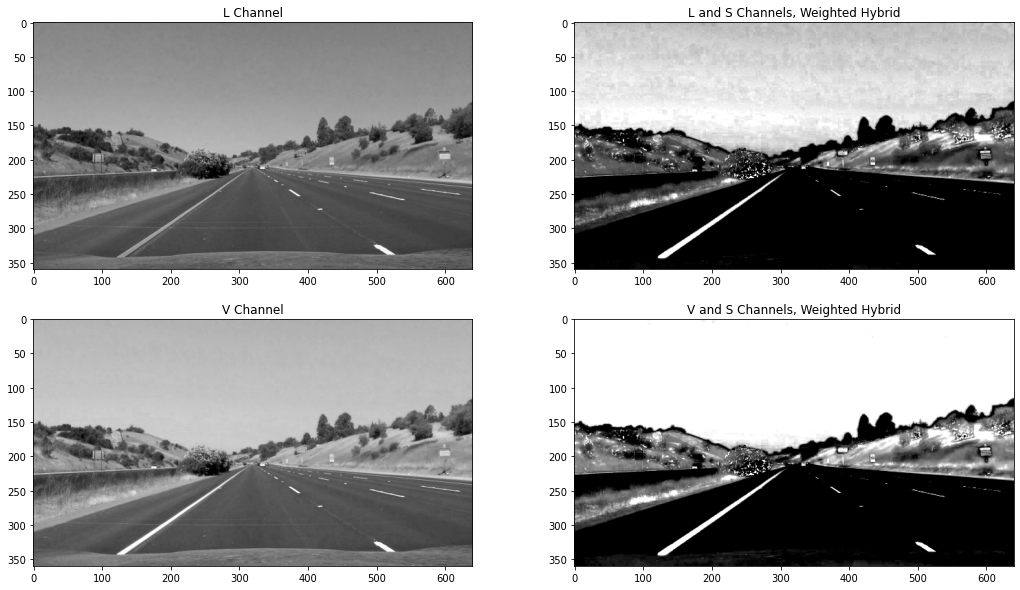

In [4]:
test_image_LS_hybrid = cv2.addWeighted(test_image_HLS_L, 1.5, test_image_HLS_S, 2.5, -255)
test_image_VS_hybrid = cv2.addWeighted(test_image_HSV_V, 1.5, test_image_HLS_S, 2.5, -255)

macros.grid_plot([

    [test_image_HLS_L, "L Channel"],
    [test_image_LS_hybrid, "L and S Channels, Weighted Hybrid"],
    [test_image_HSV_V, "V Channel"],
    [test_image_VS_hybrid, "V and S Channels, Weighted Hybrid"],

], rows=2)


# First, get the hood cutoff #

334


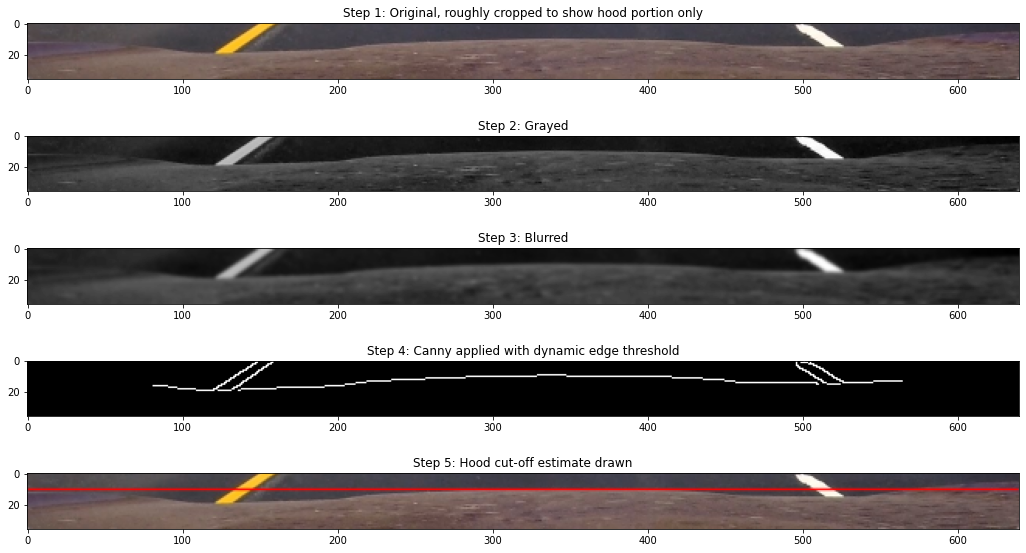

In [5]:

importlib.reload(salama_preprocessing_techniques)
HOODCUTOFF, steps = salama_preprocessing_techniques.get_hood_cutoff(test_image_BGR)
print(HOODCUTOFF)
macros.grid_plot(steps, vertical=True)


# Next, get the sky cutoff #
Here I try to find the strongest edges in the image that would signify the change from sky to road

[279, 167, 166] 204


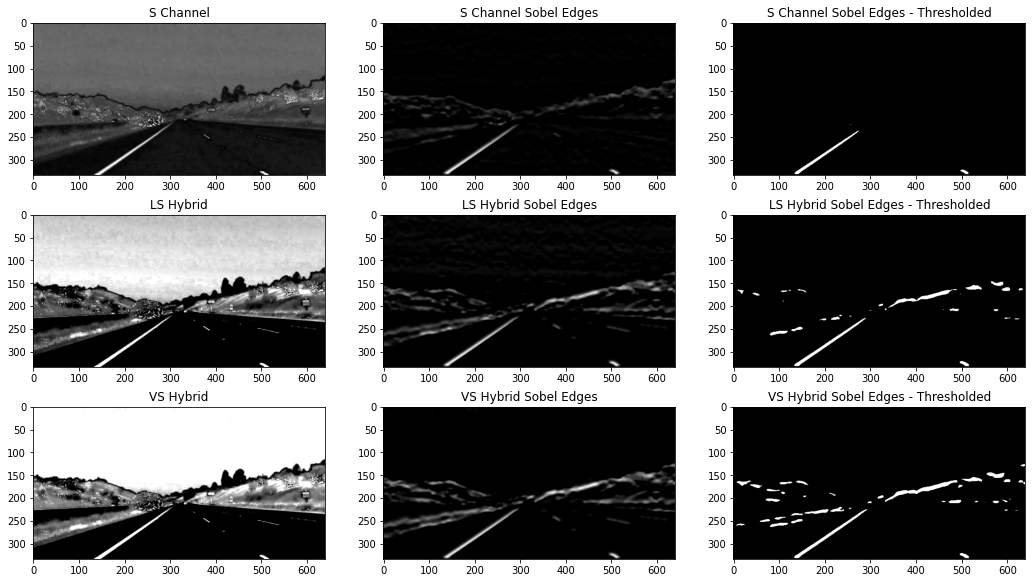

In [6]:

importlib.reload(salama_preprocessing_techniques)
SKYCUTOFF, cutoffs, steps = salama_preprocessing_techniques.get_sky_cutoff(test_image_BGR[:HOODCUTOFF])
print(cutoffs, SKYCUTOFF)
macros.grid_plot(steps, rows=3)


# And now display the final cutout #

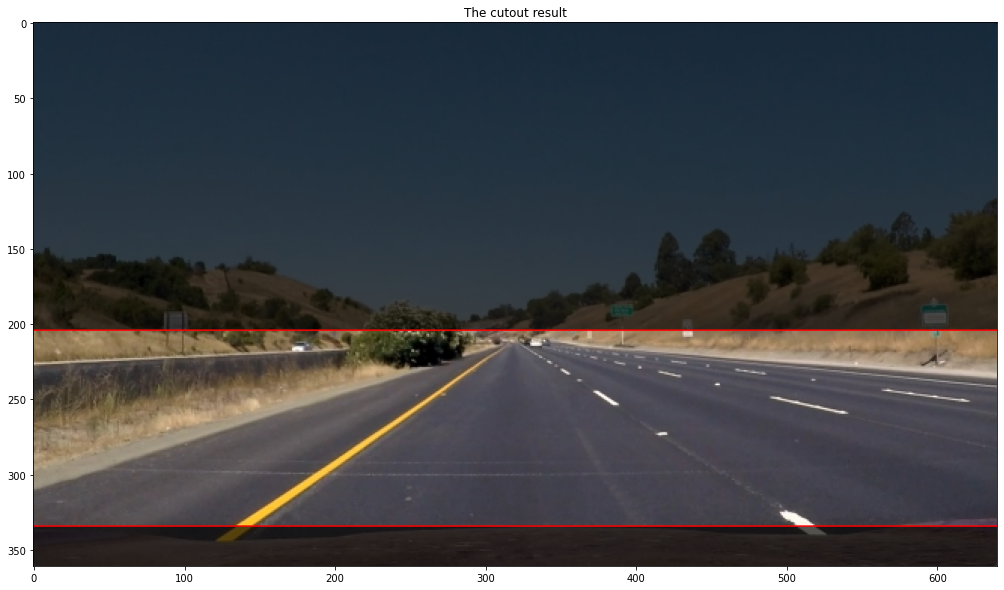

In [7]:
test_image_with_cutoffs = np.copy(test_image_RGB)
cv2.line(test_image_with_cutoffs, (0, HOODCUTOFF), (WIDTH - 1, HOODCUTOFF), (255, 0, 0), 1)
cv2.line(test_image_with_cutoffs, (0, SKYCUTOFF), (WIDTH - 1, SKYCUTOFF), (255, 0, 0), 1)
macros.show(

    cv2.vconcat([

        test_image_RGB[:SKYCUTOFF] // 3,
        test_image_with_cutoffs[SKYCUTOFF:HOODCUTOFF + 1],
        test_image_RGB[HOODCUTOFF:] // 3

    ]),

    "The cutout result"

)


# Maybe use the fact that lanes are either yellow or white? #
We don't need any colors other than those (for lane detection), so why not remove everything else?

Let's try two color spaces, HLS and CIELab; which supposedly isolate colors from lightness so should help detecting raw yellows

#### First, some calibration ####

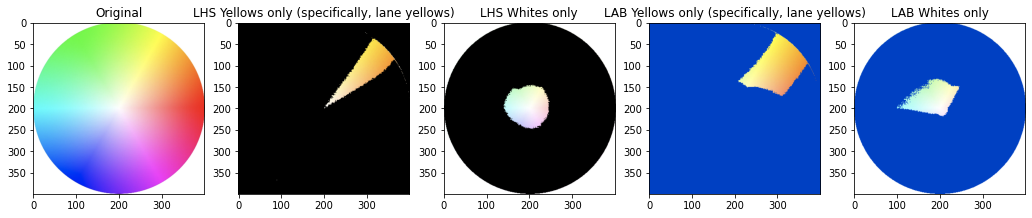

In [8]:
importlib.reload(salama_preprocessing_techniques)

color_wheel_BGR = macros.load_image("./assets/color_wheel_for_calibration.png")

_, _, LHS_threshold_steps = \
    salama_preprocessing_techniques.color_thresholded_edges_pre(color_wheel_BGR,
                                                                salama_preprocessing_techniques.HLS_COLORSPACE_THRESH)

_, _, LAB_threshold_steps = \
    salama_preprocessing_techniques.color_thresholded_edges_pre(color_wheel_BGR,
                                                                salama_preprocessing_techniques.LAB_COLORSPACE_THRESH)

macros.grid_plot([

    [cv2.cvtColor(color_wheel_BGR, cv2.COLOR_BGR2RGB), "Original"],
    [cv2.cvtColor(LHS_threshold_steps[0], cv2.COLOR_HLS2RGB), "LHS Yellows only (specifically, lane yellows)"],
    [cv2.cvtColor(LHS_threshold_steps[1], cv2.COLOR_HLS2RGB), "LHS Whites only"],
    [cv2.cvtColor(LAB_threshold_steps[0], cv2.COLOR_LAB2RGB), "LAB Yellows only (specifically, lane yellows)"],
    [cv2.cvtColor(LAB_threshold_steps[1], cv2.COLOR_LAB2RGB), "LAB Whites only"],

])


#### And now the technique in use ####

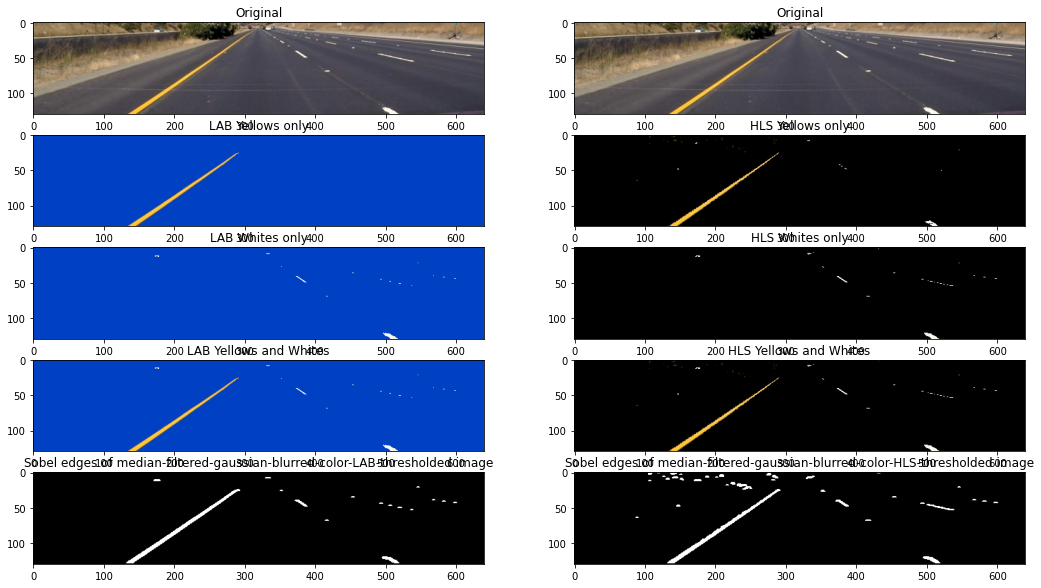

In [9]:
importlib.reload(salama_preprocessing_techniques)

HLS_color_thresholded_edges, HLS_color_thresholded_frame, HLS_color_thresholding_steps = \
    salama_preprocessing_techniques.color_thresholded_edges_pre(test_image_BGR[SKYCUTOFF:HOODCUTOFF],
                                                                salama_preprocessing_techniques.HLS_COLORSPACE_THRESH)

LAB_color_thresholded_edges, LAB_color_thresholded_frame, LAB_color_thresholding_steps = \
    salama_preprocessing_techniques.color_thresholded_edges_pre(test_image_BGR[SKYCUTOFF:HOODCUTOFF],
                                                                salama_preprocessing_techniques.LAB_COLORSPACE_THRESH)

macros.grid_plot([

    [test_image_RGB[SKYCUTOFF:HOODCUTOFF], "Original"],
    [test_image_RGB[SKYCUTOFF:HOODCUTOFF], "Original"],

    [cv2.cvtColor(LAB_color_thresholding_steps[0], cv2.COLOR_LAB2RGB), "LAB Yellows only"],
    [cv2.cvtColor(HLS_color_thresholding_steps[0], cv2.COLOR_HLS2RGB), "HLS Yellows only"],

    [cv2.cvtColor(LAB_color_thresholding_steps[1], cv2.COLOR_LAB2RGB), "LAB Whites only"],
    [cv2.cvtColor(HLS_color_thresholding_steps[1], cv2.COLOR_HLS2RGB), "HLS Whites only"],

    [cv2.cvtColor(LAB_color_thresholded_frame, cv2.COLOR_LAB2RGB), "LAB Yellows and Whites"],
    [cv2.cvtColor(HLS_color_thresholded_frame, cv2.COLOR_HLS2RGB), "HLS Yellows and Whites"],

    [LAB_color_thresholded_edges, "Sobel edges of median-filtered-gaussian-blurred-color-LAB-thresholded image"],
    [HLS_color_thresholded_edges, "Sobel edges of median-filtered-gaussian-blurred-color-HLS-thresholded image"]

], rows=5)


# What about adaptive thresholding? #

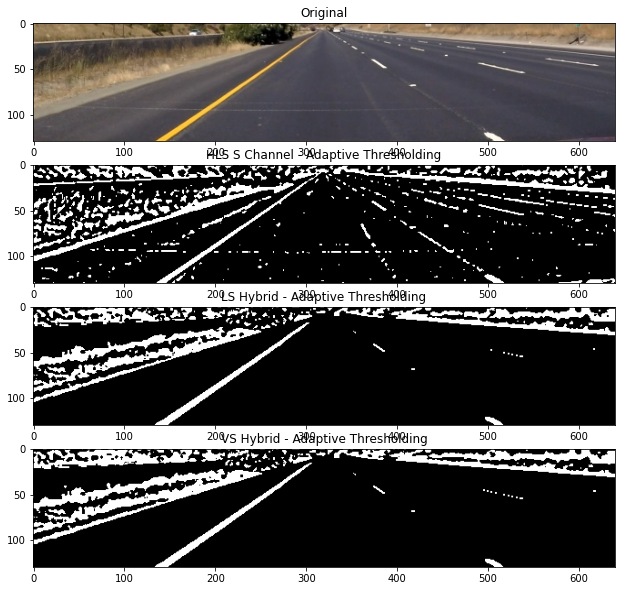

In [10]:
importlib.reload(salama_preprocessing_techniques)

test_image_HLS_S_thresholded_adaptive =\
    salama_preprocessing_techniques.adaptive_thresholding_pre(test_image_HLS_L[SKYCUTOFF:HOODCUTOFF])

test_image_LS_hybrid_thresholded_adaptive =\
    salama_preprocessing_techniques.adaptive_thresholding_pre(test_image_LS_hybrid[SKYCUTOFF:HOODCUTOFF])

test_image_VS_hybrid_thresholded_adaptive =\
    salama_preprocessing_techniques.adaptive_thresholding_pre(test_image_VS_hybrid[SKYCUTOFF:HOODCUTOFF])

macros.grid_plot([

    [test_image_RGB[SKYCUTOFF:HOODCUTOFF], "Original"],
    [test_image_HLS_S_thresholded_adaptive, "HLS S Channel - Adaptive Thresholding"],
    [test_image_LS_hybrid_thresholded_adaptive, "LS Hybrid - Adaptive Thresholding"],
    [test_image_VS_hybrid_thresholded_adaptive, "VS Hybrid - Adaptive Thresholding"],

], vertical=True)


# The Sobels #

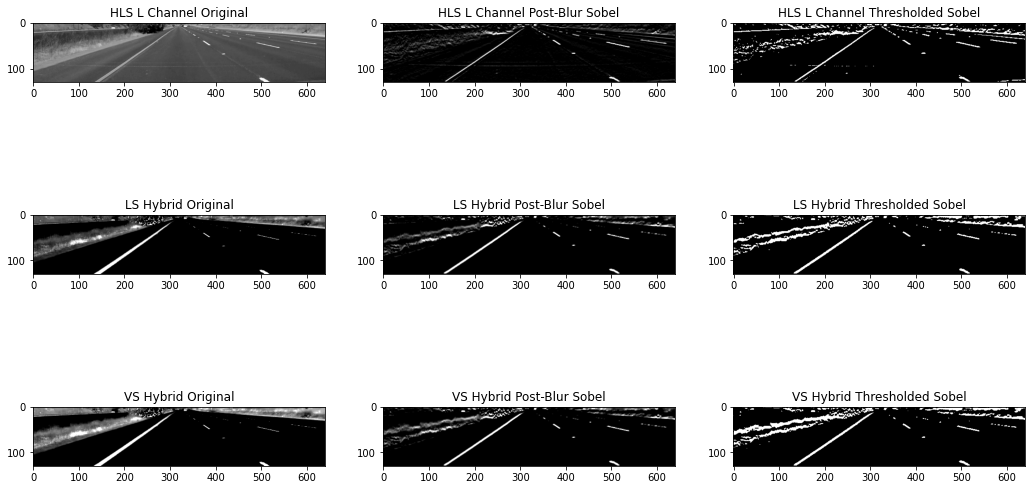

In [11]:
importlib.reload(salama_preprocessing_techniques)

test_image_HLS_L_sobel_thresh, test_image_HLS_L_sobel_raw =\
    salama_preprocessing_techniques.sobel_pre(test_image_HLS_L[SKYCUTOFF:HOODCUTOFF], (1, 3))

test_image_LS_hybrid_sobel_thresh, test_image_LS_hybrid_sobel_raw =\
    salama_preprocessing_techniques.sobel_pre(test_image_LS_hybrid[SKYCUTOFF:HOODCUTOFF], (1, 5))

test_image_VS_hybrid_sobel_thresh, test_image_VS_hybrid_sobel_raw =\
    salama_preprocessing_techniques.sobel_pre(test_image_VS_hybrid[SKYCUTOFF:HOODCUTOFF], (1, 5))

macros.grid_plot([

    [test_image_HLS_L[SKYCUTOFF:HOODCUTOFF], "HLS L Channel Original"],
    [test_image_HLS_L_sobel_raw, "HLS L Channel Post-Blur Sobel"],
    [test_image_HLS_L_sobel_thresh, "HLS L Channel Thresholded Sobel"],

    [test_image_LS_hybrid[SKYCUTOFF:HOODCUTOFF], "LS Hybrid Original"],
    [test_image_LS_hybrid_sobel_raw, "LS Hybrid Post-Blur Sobel"],
    [test_image_LS_hybrid_sobel_thresh, "LS Hybrid Thresholded Sobel"],

    [test_image_VS_hybrid[SKYCUTOFF:HOODCUTOFF], "VS Hybrid Original"],
    [test_image_VS_hybrid_sobel_raw, "VS Hybrid Post-Blur Sobel"],
    [test_image_VS_hybrid_sobel_thresh, "VS Hybrid Thresholded Sobel"],

], rows=3)


# "Top/white hat" transform? #
Should supposedly bring out the details of any white object atop of any black

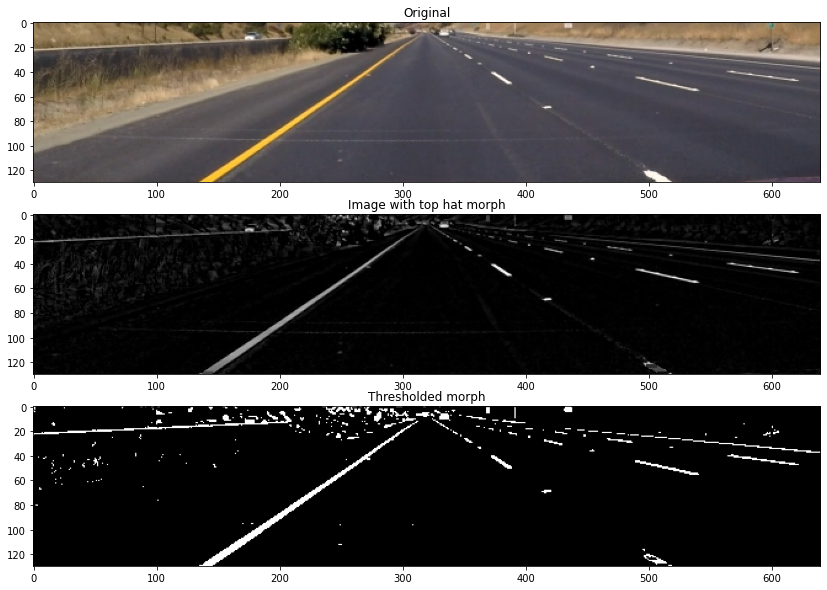

In [12]:
importlib.reload(salama_preprocessing_techniques)

test_image_TOPHAT_thresholded, test_image_TOPHAT =\
    salama_preprocessing_techniques.morph_top_hat_pre(test_image_BGR[SKYCUTOFF:HOODCUTOFF])

macros.grid_plot([

    [test_image_RGB[SKYCUTOFF:HOODCUTOFF], "Original"],
    [test_image_TOPHAT, "Image with top hat morph"],
    [test_image_TOPHAT_thresholded, "Thresholded morph"]

], vertical=True)


# How about, inverse black hat? #
Black hat works opposite to white/top hat... How about use it to *remove* noise?

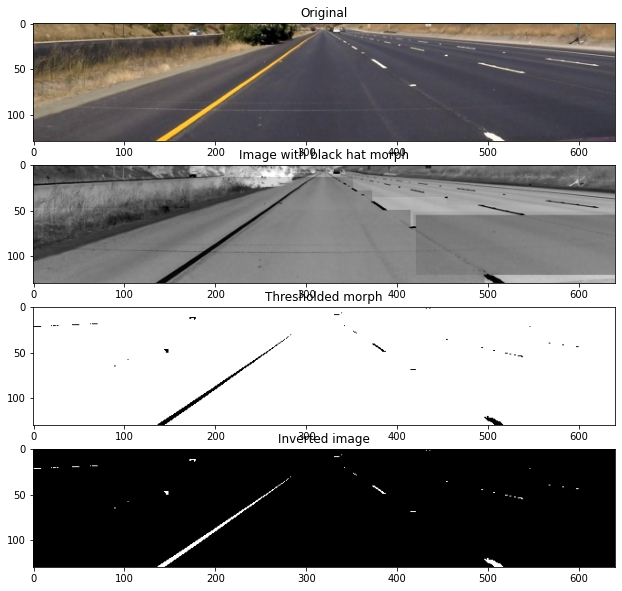

In [13]:
importlib.reload(salama_preprocessing_techniques)

image_inv_BLACKHAT_thresholded, image_BLACKHAT_thresholded, image_BLACKHAT =\
    salama_preprocessing_techniques.morph_inv_black_hat_pre(test_image_BGR[SKYCUTOFF:HOODCUTOFF])

macros.grid_plot([

    [test_image_RGB[SKYCUTOFF:HOODCUTOFF], "Original"],
    [image_BLACKHAT, "Image with black hat morph"],
    [image_BLACKHAT_thresholded, "Thresholded morph"],
    [image_inv_BLACKHAT_thresholded, "Inverted image"]

], vertical=True)


# Canny then Hough transform? #
This works best provided an arbitrary/hard-coded ROI...

I am trying to avoid this though; but this bounds the Hough transform algorithm for failure due to excessive noise

It would probably be better to try the Hough transform *after* voting ensemble to detect the lines afterwards

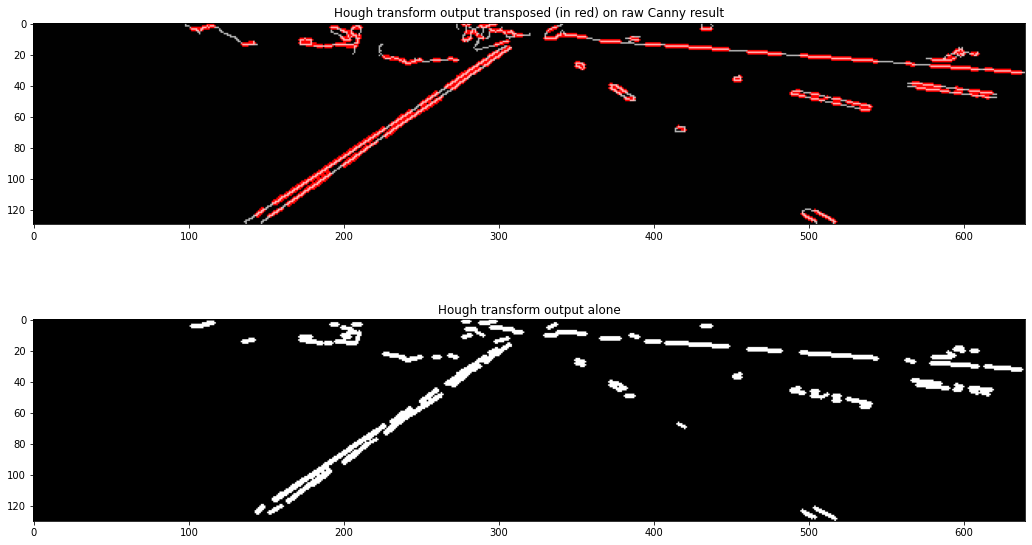

In [14]:
importlib.reload(salama_preprocessing_techniques)

raw_canny =\
    salama_preprocessing_techniques.canny_raw_pre(
        cv2.cvtColor(test_image_BGR[SKYCUTOFF:HOODCUTOFF], cv2.COLOR_BGR2GRAY))

edges_detected, canny_hough_canvas\
    = salama_preprocessing_techniques.hough_transform_raw_pre(raw_canny)

canny_hough_canvas_red = cv2.cvtColor(canny_hough_canvas, cv2.COLOR_GRAY2RGB)
canny_hough_canvas_red[:, :, 1] = 0
canny_hough_canvas_red[:, :, 2] = 0

macros.grid_plot([

    [cv2.addWeighted(canny_hough_canvas_red, 1,
                     cv2.cvtColor(raw_canny, cv2.COLOR_GRAY2RGB), 0.7,
                     1), "Hough transform output transposed (in red) on raw Canny result"],
    [canny_hough_canvas, "Hough transform output alone"],

], vertical=True)


# How about all of them? #
#### Can perform a voting ensemble on: ####
- Color-Thresholded Canny (HLS and LAB)
- Channel Adaptive Threshold (S, LS, VS)
- Channel-Thresholded Sobels (S, LS, VS)
- Top (White) Hat Morph
- Inverted Black Hat Morph
- Raw Canny

#### Followed by: ####
- Probabilistic Hough Transform

### First, a demonstration ###

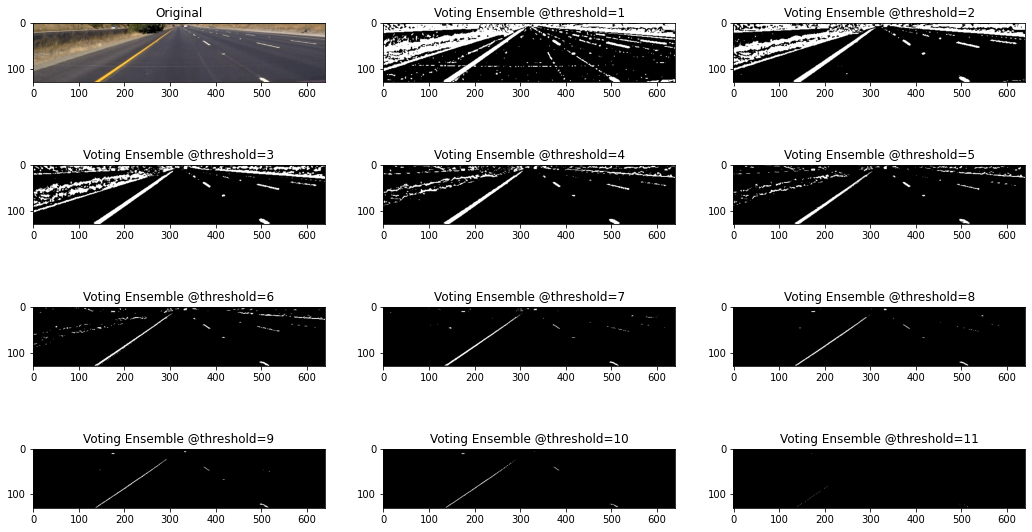

In [15]:
importlib.reload(salama_preprocessing_techniques)
voting_ensemble_results = [[test_image_RGB[SKYCUTOFF:HOODCUTOFF], "Original"]]

for i in range(1, 12):  # For the eleven techniques above

    voting_ensemble_results.append(

        [salama_preprocessing_techniques.edge_voting_ensemble([

            HLS_color_thresholded_edges,
            LAB_color_thresholded_edges,
            test_image_HLS_S_thresholded_adaptive,
            test_image_LS_hybrid_thresholded_adaptive,
            test_image_VS_hybrid_thresholded_adaptive,
            test_image_HLS_L_sobel_thresh,
            test_image_LS_hybrid_sobel_thresh,
            test_image_VS_hybrid_sobel_thresh,
            test_image_TOPHAT_thresholded,
            image_inv_BLACKHAT_thresholded,
            raw_canny,

        ], i), f'Voting Ensemble @threshold={i}']

    )

macros.grid_plot(voting_ensemble_results, rows=4)


### Alright let's use the best result ###

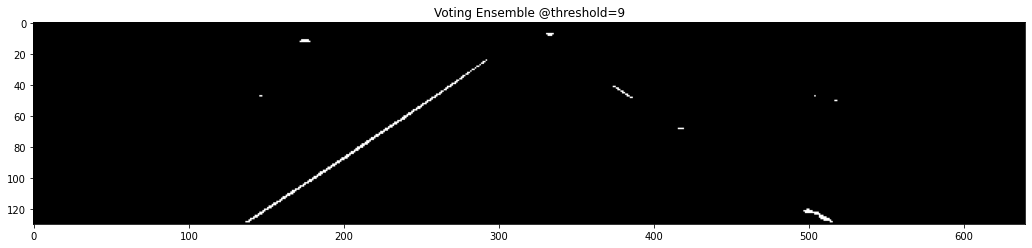

In [16]:
voting_ensemble_best_result = voting_ensemble_results[9]  # @threshold=9
macros.show(voting_ensemble_best_result[0], voting_ensemble_best_result[1])


# Hough, again? #
This time applied on the result of the voting ensemble

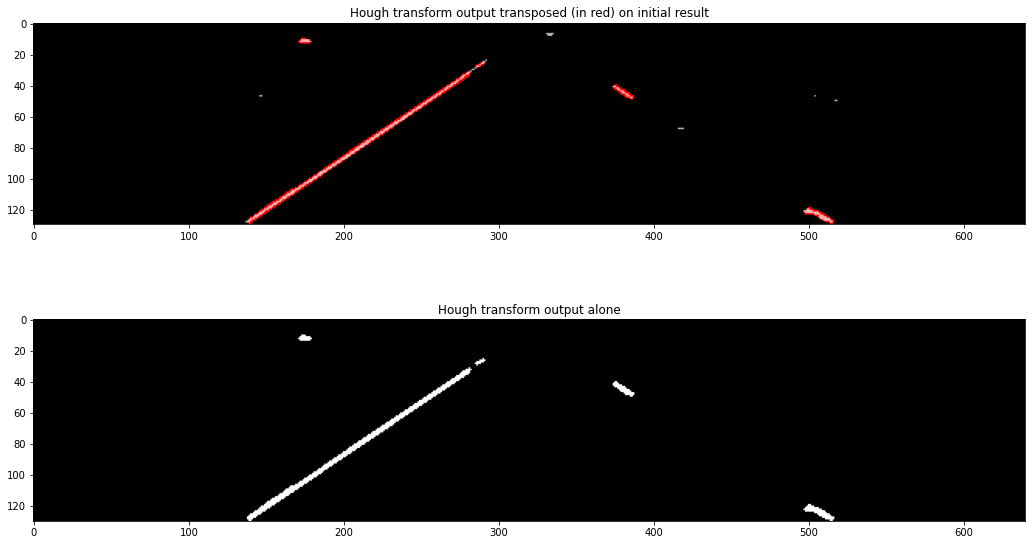

In [17]:
importlib.reload(salama_preprocessing_techniques)

voting_ensemble_edges, voting_ensemble_edges_canvas =\
    salama_preprocessing_techniques.hough_transform_raw_pre(voting_ensemble_best_result[0])

voting_ensemble_edges_canvas_red = cv2.cvtColor(voting_ensemble_edges_canvas, cv2.COLOR_GRAY2RGB)
voting_ensemble_edges_canvas_red[:, :, 1] = 0
voting_ensemble_edges_canvas_red[:, :, 2] = 0

macros.grid_plot([

    [cv2.addWeighted(voting_ensemble_edges_canvas_red, 1,
                     cv2.cvtColor(voting_ensemble_best_result[0], cv2.COLOR_GRAY2RGB), 0.7,
                     1), "Hough transform output transposed (in red) on initial result"],
    [voting_ensemble_edges_canvas, "Hough transform output alone"],

], vertical=True)


# Well then, moment of truth! #

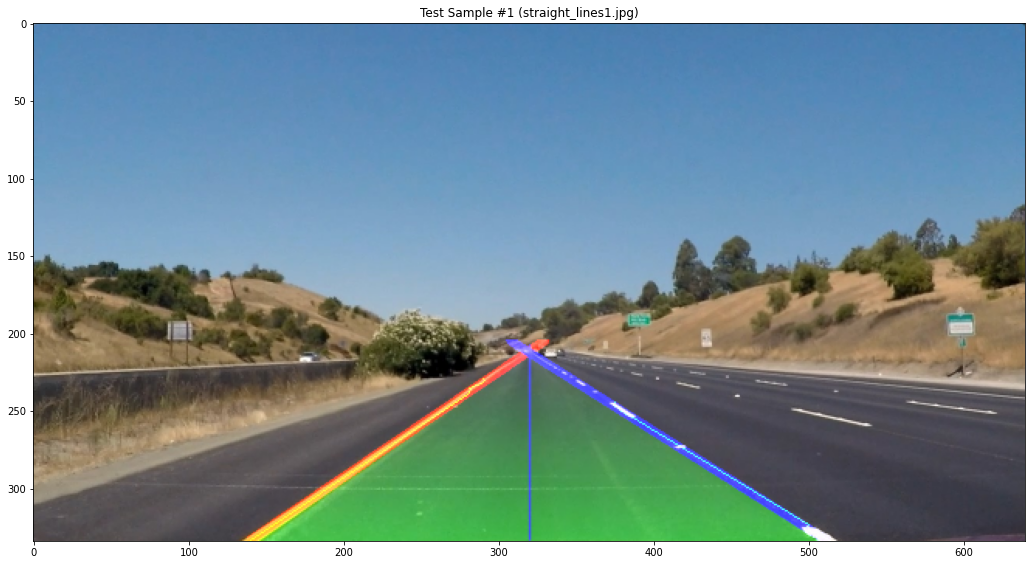

In [18]:
importlib.reload(salama_preprocessing_techniques)
importlib.reload(salama_lane_detection_algorithm)

ready_for_lane_detection = np.copy(voting_ensemble_edges_canvas)

# Extract lane data (ld) with 1st order peeking center detection algorithm
ld = salama_lane_detection_algorithm.peeking_center_detect(ready_for_lane_detection, 1)
lane = ld.draw(test_image_BGR, SKYCUTOFF, HOODCUTOFF, debugging=True)

macros.show(cv2.vconcat(

    [
        test_image_RGB[:SKYCUTOFF],
        cv2.cvtColor(cv2.addWeighted(lane, 1, test_image_BGR[SKYCUTOFF:HOODCUTOFF], 1, 0), cv2.COLOR_BGR2RGB),
        # test_image_RGB[HOODCUTOFF:]  # Looks better with the hood cutout tbh
    ]

), "Test Sample #1 (straight_lines1.jpg)")


# Let's test the other samples #
Now that we've seen how the pipeline works for the first frame in a stream, let's try all the test samples

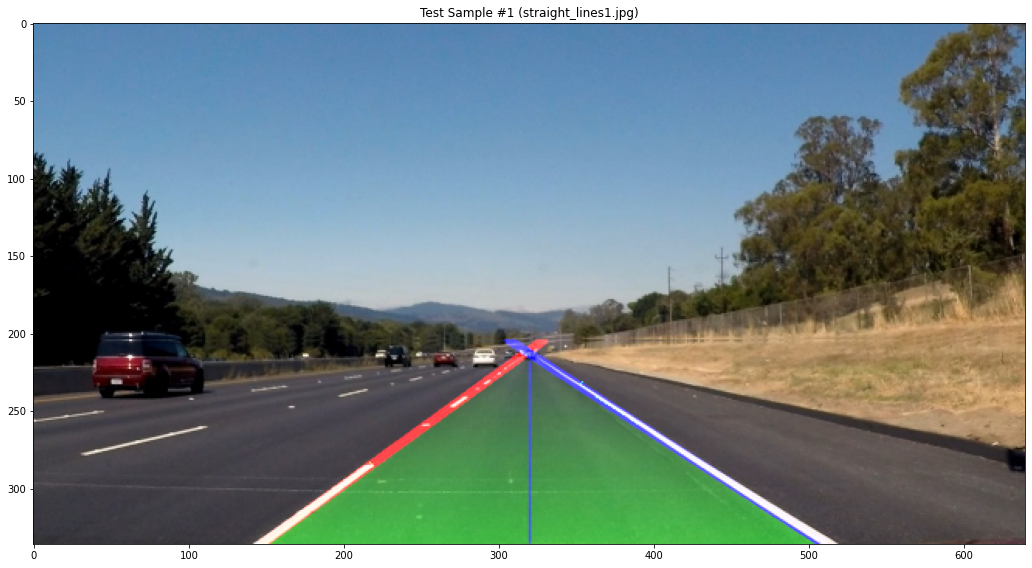

In [21]:
importlib.reload(salama_preprocessing_techniques)
importlib.reload(salama_lane_detection_algorithm)
importlib.reload(pipeline_phase1)

test_image_BGR_2 = macros.load_image("./assets/test_images/straight_lines2.jpg", (WIDTH, HEIGHT))
test_image_RGB_2 = cv2.cvtColor(test_image_BGR_2, cv2.COLOR_BGR2RGB)
ld, hoodcutoff, skycutoff = pipeline_phase1.get_initial_lane(test_image_BGR_2)  # lane data
lc = ld.draw(test_image_BGR_2, skycutoff, hoodcutoff, debugging=True)  # lane canvas
macros.show(cv2.vconcat(

    [
        test_image_RGB_2[:SKYCUTOFF],
        cv2.cvtColor(cv2.addWeighted(lc, 1, test_image_BGR_2[skycutoff:hoodcutoff], 1, 0), cv2.COLOR_BGR2RGB),
        # test_image_RGB_2[HOODCUTOFF:]
    ]

), "Test Sample #1 (straight_lines1.jpg)")


# Alright, let's check the following six then... #

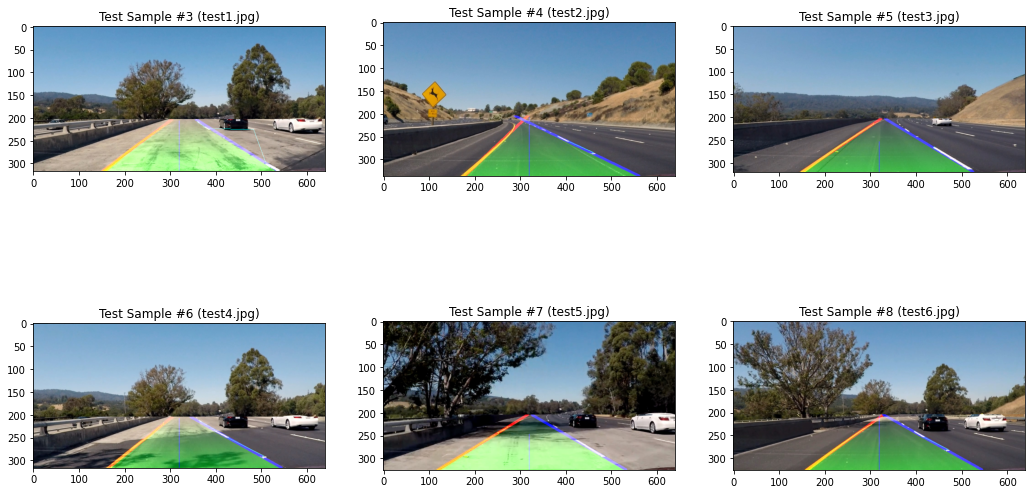

In [22]:
importlib.reload(salama_preprocessing_techniques)
importlib.reload(salama_lane_detection_algorithm)
importlib.reload(pipeline_phase1)

test_i = []
for i in range(1, 7):

    test_image_BGR_i = macros.load_image(f"./assets/test_images/test{i}.jpg", (WIDTH, HEIGHT))
    test_image_RGB_i = cv2.cvtColor(test_image_BGR_i, cv2.COLOR_BGR2RGB)
    ld, hood, sky = pipeline_phase1.get_initial_lane(test_image_BGR_i)  # lane data
    lc = ld.draw(test_image_BGR_i, sky, hood, debugging=True)  # lane canvas
    test_i.append(

        [

            cv2.vconcat(

                [
                    test_image_RGB_i[:SKYCUTOFF],
                    cv2.cvtColor(cv2.addWeighted(lc, 1, test_image_BGR_i[sky:hood], 1, 0), cv2.COLOR_BGR2RGB),
                    # test_image_RGB_2[HOODCUTOFF:]
                ]

            ), f"Test Sample #{i+2} (test{i}.jpg)"

        ]

    )

macros.grid_plot(test_i, rows=2)


# And a few more #
The following are extra samples for some tricky frames in the videos... I don't expect them to work! Considering that these frames aren't initial, the pipeline deals with them better through the adaptive process... In fact, this preview will show why it is essential to use the adaptive process for non-initial frames. Some break completely!

It was very challenging for me to try and get them right using the initial detection technique... Maybe later I'll be able to.

Trying to fine-tune the pipeline to work for them simply breaks the more important samples, so better leave it working in the general case and try and fix those corner cases in the future - or simply not fix them at all...

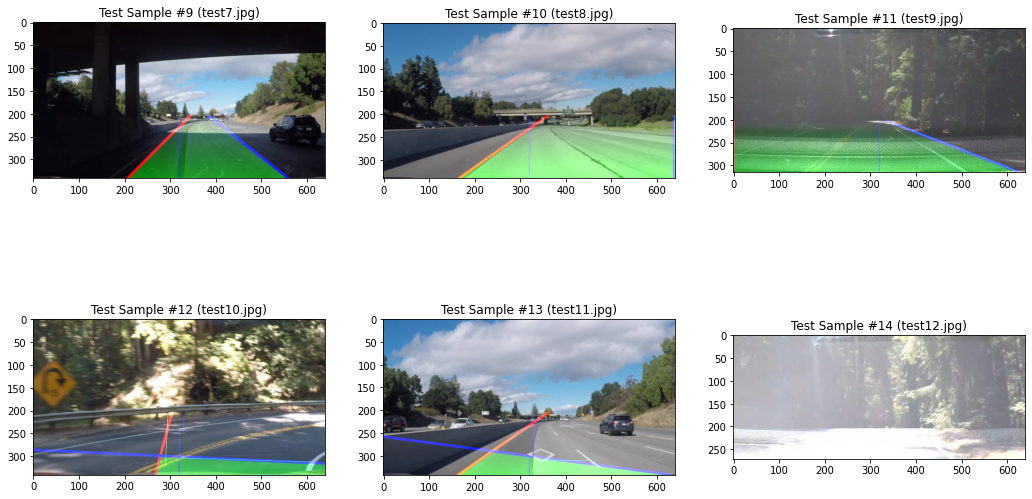

In [23]:
importlib.reload(salama_preprocessing_techniques)
importlib.reload(salama_lane_detection_algorithm)
importlib.reload(pipeline_phase1)

test_i = []
for i in range(7, 13):

    test_image_BGR_i = macros.load_image(f"./assets/test_images/test{i}.jpg", (WIDTH, HEIGHT))
    test_image_RGB_i = cv2.cvtColor(test_image_BGR_i, cv2.COLOR_BGR2RGB)
    ld, hood, sky = pipeline_phase1.get_initial_lane(test_image_BGR_i)  # lane data
    lc = ld.draw(test_image_BGR_i, sky, hood, debugging=True)  # lane canvas
    test_i.append(

        [

            cv2.vconcat(

                [
                    test_image_RGB_i[:SKYCUTOFF],
                    cv2.cvtColor(cv2.addWeighted(lc, 1, test_image_BGR_i[sky:hood], 1, 0), cv2.COLOR_BGR2RGB),
                    # test_image_RGB_2[HOODCUTOFF:]
                ]

            ), f"Test Sample #{i+2} (test{i}.jpg)"

        ]

    )

macros.grid_plot(test_i, rows=2)
